# Transfer Learning
The model weights are already downloaded to /data/transfer_learning_data, and transfer learning is a powerful tool when we do not have large data set or suitable training server.

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
local_weights_file = './data/transfer learning data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)
pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
    layer.trainable = False

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

The summary shows that the model is a DNN (deep neural network), has 20M params, and it will be super difficult to train on a normal laptop.

## Add dense layers to the classifer
The trained model is a DNN but the last layer is too specialized, then we need to 'simplify' from the middle layer. Here I choose 'mixed7' as the beginning of the dense layer appending.

In [4]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
# Here the dropout is necessary to prevent overfitting
x = layers.Dropout(0.2)(x)
x = layers.Dense  (1, activation='sigmoid')(x)
model = Model(pre_trained_model.input, x)
model.summary()
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Add transfer learning and image argumentation together

In [8]:
source_path = './data/cats-and-dogs/PetImages/'
source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')
root_dir = './data'
training_path = os.path.join(root_dir, "training")
test_path = os.path.join(root_dir, "validation")
training_path_cats = os.path.join(training_path, "cats")
training_path_dogs = os.path.join(training_path, "dogs")
test_path_cats = os.path.join(test_path, "cats")
test_path_dogs = os.path.join(test_path, "dogs")

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory=training_path,
                              batch_size=100,
                              class_mode='binary',
                              target_size=(150, 150))
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(directory=test_path,
                              batch_size=100,
                              class_mode='binary',
                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
history = model .fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
155/225 [===================>..........] - ETA: 1:10 - loss: 0.2588 - accuracy: 0.9011

D:\ApplicationApps\Python3.8\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
D:\ApplicationApps\Python3.8\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
D:\ApplicationApps\Python3.8\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
D:\ApplicationApps\Python3.8\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
D:\ApplicationApps\Python3.8\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
D:\ApplicationApps\Python3.8\lib\s

225/225 [==============================] - 241s 1s/step - loss: 0.2280 - accuracy: 0.9119 - val_loss: 0.0838 - val_accuracy: 0.9704
Epoch 2/15
225/225 [==============================] - 178s 790ms/step - loss: 0.1545 - accuracy: 0.9379 - val_loss: 0.1014 - val_accuracy: 0.9648
Epoch 3/15
225/225 [==============================] - 179s 796ms/step - loss: 0.1422 - accuracy: 0.9432 - val_loss: 0.1062 - val_accuracy: 0.9652
Epoch 4/15
225/225 [==============================] - 178s 792ms/step - loss: 0.1361 - accuracy: 0.9466 - val_loss: 0.0983 - val_accuracy: 0.9644
Epoch 5/15
225/225 [==============================] - 179s 793ms/step - loss: 0.1339 - accuracy: 0.9495 - val_loss: 0.0907 - val_accuracy: 0.9712
Epoch 6/15
225/225 [==============================] - 180s 798ms/step - loss: 0.1264 - accuracy: 0.9517 - val_loss: 0.0751 - val_accuracy: 0.9724
Epoch 7/15
225/225 [==============================] - 179s 795ms/step - loss: 0.1288 - accuracy: 0.9500 - val_loss: 0.0791 - val_accuracy:

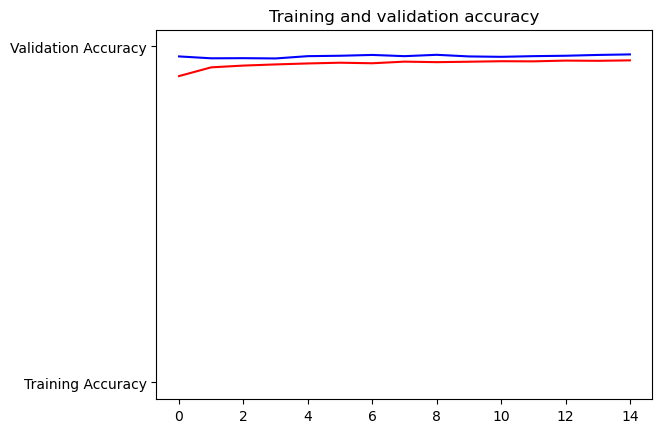

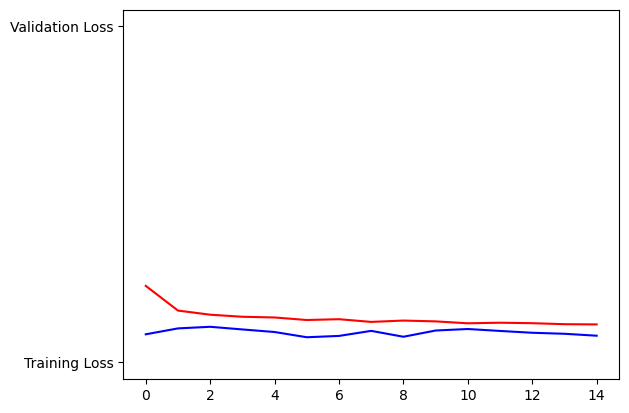

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()



In [15]:
model.save_weights('./checkpoints/cnn_transfer_learning_data')

The final result is quite decent, and it's not always the best way to improve the accuracy as some datasets are not trained by others.